In [1]:
import pandas as pd
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
import matplotlib.pyplot as plt
import os
import logging
import spacy
from spacy import displacy

In [2]:
#!python3 -m spacy download en_core_web_sm

In [3]:
NER = spacy.load('en_core_web_md')

In [4]:
import re   #regular expression library to cleanup the text
import networkx as nx #for network analysis
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import os

# Data Cleaning

In [5]:
with open('pride.txt', 'r', encoding='utf8') as rf:
    text = rf.read()

text = text[text.find("Chapter 61")+len("Chapter 61"):text.find("End of the Project Gutenberg EBook")].strip()
text = re.sub(r'\n {6}', ' ', text)
text = text.replace(".", "")

paragraphs = text.split("\n")

print(text[:1000])

Chapter 1
 It is a truth universally acknowledged, that a single man in possession of a good fortune, must be in want of a wife
 However little known the feelings or views of such a man may be on his first entering a neighbourhood, this truth is so well fixed in the minds of the surrounding families, that he is considered the rightful property of some one or other of their daughters
 “My dear Mr Bennet,” said his lady to him one day, “have you heard that Netherfield Park is let at last?”
 Mr Bennet replied that he had not
 “But it is,” returned she; “for Mrs Long has just been here, and she told me all about it”
 Mr Bennet made no answer
 “Do you not want to know who has taken it?” cried his wife impatiently
 “_You_ want to tell me, and I have no objection to hearing it”
 This was invitation enough
 “Why, my dear, you must know, Mrs Long says that Netherfield is taken by a young man of large fortune from the north of England; that he came down on Monday in a chaise and four to see the 

# Load character name

In [6]:
# First, split the book into chapters before removing numbers and special characters
#with open('pp_characters.txt', 'r', encoding='utf8') as rf:
 #   characters = rf.read().split("\n")
  #  characters = [character.split(", ") for character in characters]

In [7]:
#print(characters)

In [8]:
characters_df = pd.read_csv('pp_characters.csv')
characters_df.head()

index   firstname     lastname
0    1.0   Elizabeth       Bennet
1    2.0    Mr Darcy  Fitzwilliam
2    3.0   Mr Bennet          NaN
3    4.0  Mrs Bennet          NaN
4    5.0        Jane       Bennet

In [9]:
output_dir = "Chapters"
os.makedirs(output_dir, exist_ok=True)

chapters = re.split(r"Chapter \d{1,2}", text)

for i, chapter_text in enumerate(chapters, start=0):
    if not chapter_text.strip():  
        continue
    filename = f"{output_dir}/{i}.txt"  
    with open(filename, "w", encoding="utf-8") as f:
        f.write(chapter_text.strip())  

print(f"Saved {len(chapters)} chapters into the '{output_dir}' directory.")

In [10]:
book_doc = NER(text)

In [11]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [12]:
from spacy import displacy

In [13]:
# Visualize identified entities
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

# get named entity list per sentence

In [14]:
sent_entity_df = []

# Loop through sentences, store named entity list for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

In [15]:
sent_entity_df

sentence  \
0     (Chapter, 1, \n , It, is, a, truth, universall...   
1             (Single, ,, my, dear, ,, to, be, sure, !)   
2     (A, single, man, of, large, fortune, ;, four, ...   
3     (How, can, it, affect, them, ?, ”, \n , “, My,...   
4     (You, must, know, that, I, am, thinking, of, h...   
...                                                 ...   
1300  (In, society, so, superior, to, what, she, had...   
1301  (She, was, not, of, so, ungovernable, a, tempe...   
1302  (If, you, love, Mr, Darcy, half, as, well, as,...   
1303  (Her, mind, received, knowledge, which, had, n...   
1304  (But, at, length, ,, by, Elizabeth, ’s, persua...   

                                               entities  
0     [Chapter 1, first, Bennet, one day, Netherfiel...  
1                                                    []  
2                                                [four]  
3                                              [Bennet]  
4                                                 [one]  
...                                                 ...  
1300                                                 []  
1301  [Lydia, Lydia, Lydia, Mrs Wickham, Mrs Bennet,...  
1302  [Darcy, half, Wickham, Wickham, about three or...  
1303  [Elizabeth, more than ten years, Catherine, El...  
1304  [Elizabeth, Pemberley, Darcy, Elizabeth, Derby...  

[1305 rows x 2 columns]

# Build a filter

In [16]:
def filter_entity(ent_list, characters_df):
    return [ent for ent in ent_list 
            if ent in list(characters_df.firstname) 
            or ent in list(characters_df.lastname)]

In [17]:
filter_entity(["Darcy", "Fay", "2"], characters_df)

['Darcy']

In [18]:
sent_entity_df['characters_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))

sent_entity_df_filtered = sent_entity_df[sent_entity_df['characters_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

sentence  \
0   (Chapter, 1, \n , It, is, a, truth, universall...   
3   (How, can, it, affect, them, ?, ”, \n , “, My,...   
6   (But, it, is, very, likely, that, he, _, may, ...   
7   (I, certainly, _, have, _, had, my, share, of,...   
8   (Indeed, you, must, go, ,, for, it, will, be, ...   
9   (the, preference, ”, \n , “, They, have, none,...   
12  (But, I, hope, you, will, get, over, it, ,, an...   
13  (Her, _, mind, was, less, difficult, to, devel...   
14  (Mr, Bingley, likes, ,, ”, said, her, mother, ...   
15  (She, is, a, selfish, ,, hypocritical, woman, ...   

                                             entities  \
0   [Chapter 1, first, Bennet, one day, Netherfiel...   
3                                            [Bennet]   
6                                      [one, Bingley]   
7           [five, Bingley, one, William, Lady Lucas]   
8    [Bingley, Lizzy, Lizzy, half, Jane, half, Lydia]   
9                                     [Lizzy, Bennet]   
12  [four thousand a year, twenty, Bennet, three, ...   
13  [Chapter 2, Bennet, Bingley, the evening, seco...   
14                [Bingley, Elizabeth, Mrs Long, two]   
15                        [Bennet, Mrs Bennet, Kitty]   

                  characters_entities  
0   [Bennet, Bennet, Bennet, Bingley]  
3                            [Bennet]  
6                           [Bingley]  
7      [Bingley, William, Lady Lucas]  
8              [Bingley, Jane, Lydia]  
9                            [Bennet]  
12                           [Bennet]  
13         [Bennet, Bingley, Bingley]  
14               [Bingley, Elizabeth]  
15               [Bennet, Mrs Bennet]

In [19]:
# Take only first name of characters
sent_entity_df_filtered['characters_entities'] = sent_entity_df_filtered['characters_entities'].apply(lambda x: [item.split()[0] 
                                                                                                               for item in x])

/var/folders/x4/gn012t7s4n1867l1f1_5g6rm0000gn/T/ipykernel_6213/1389849222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['characters_entities'] = sent_entity_df_filtered['characters_entities'].apply(lambda x: [item.split()[0]


In [20]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

sentence  \
0     (Chapter, 1, \n , It, is, a, truth, universall...   
3     (How, can, it, affect, them, ?, ”, \n , “, My,...   
6     (But, it, is, very, likely, that, he, _, may, ...   
7     (I, certainly, _, have, _, had, my, share, of,...   
8     (Indeed, you, must, go, ,, for, it, will, be, ...   
...                                                 ...   
1299  (So, near, a, vicinity, to, her, mother, and, ...   
1301  (She, was, not, of, so, ungovernable, a, tempe...   
1302  (If, you, love, Mr, Darcy, half, as, well, as,...   
1303  (Her, mind, received, knowledge, which, had, n...   
1304  (But, at, length, ,, by, Elizabeth, ’s, persua...   

                                               entities  \
0     [Chapter 1, first, Bennet, one day, Netherfiel...   
3                                              [Bennet]   
6                                        [one, Bingley]   
7             [five, Bingley, one, William, Lady Lucas]   
8      [Bingley, Lizzy, Lizzy, half, Jane, half, Lydia]   
...                                                 ...   
1299  [Meryton, Derbyshire, Jane, Elizabeth, thirty ...   
1301  [Lydia, Lydia, Lydia, Mrs Wickham, Mrs Bennet,...   
1302  [Darcy, half, Wickham, Wickham, about three or...   
1303  [Elizabeth, more than ten years, Catherine, El...   
1304  [Elizabeth, Pemberley, Darcy, Elizabeth, Derby...   

                                    characters_entities  
0                     [Bennet, Bennet, Bennet, Bingley]  
3                                              [Bennet]  
6                                             [Bingley]  
7                              [Bingley, William, Lady]  
8                                [Bingley, Jane, Lydia]  
...                                                 ...  
1299                                  [Jane, Elizabeth]  
1301  [Lydia, Lydia, Lydia, Mrs, Mary, Wickham, Lydi...  
1302  [Darcy, Wickham, Wickham, Darcy, Elizabeth, Ja...  
1303                             [Elizabeth, Elizabeth]  
1304                      [Elizabeth, Darcy, Elizabeth]  

[730 rows x 3 columns]

# use nlp to analyze relationship

In [21]:
window_size = 5
relationships = []

for i in range(sent_entity_df.index[-1]):
    end_i = min(i+5, sent_entity_df.index[-1])
    char_list = sum((sent_entity_df.loc[i: end_i].characters_entities), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [22]:
relationship_df = pd.DataFrame(relationships)

In [92]:
relationship_df.to_csv("pp_relationship_df.csv",index=False)

In [23]:
pd.set_option('display.max_rows', None)
relationship_df

source          target
0              Bennet         Bingley
1             Bingley          Bennet
2              Bennet         Bingley
3              Bennet         Bingley
4             Bingley         William
5             William      Lady Lucas
6              Bennet         Bingley
7             Bingley         William
8             William      Lady Lucas
9          Lady Lucas         Bingley
10            Bingley            Jane
11               Jane           Lydia
12            Bingley         William
13            William      Lady Lucas
14         Lady Lucas         Bingley
15            Bingley            Jane
16               Jane           Lydia
17              Lydia          Bennet
18            Bingley         William
19            William      Lady Lucas
20         Lady Lucas         Bingley
21            Bingley            Jane
22               Jane           Lydia
23              Lydia          Bennet
24            Bingley         William
25            William      Lady Lucas
26         Lady Lucas         Bingley
27            Bingley            Jane
28               Jane           Lydia
29              Lydia          Bennet
30            Bingley         William
31            William      Lady Lucas
32         Lady Lucas         Bingley
33            Bingley            Jane
34               Jane           Lydia
35              Lydia          Bennet
36            Bingley            Jane
37               Jane           Lydia
38              Lydia          Bennet
39             Bennet         Bingley
40             Bennet         Bingley
41            Bingley       Elizabeth
42             Bennet         Bingley
43            Bingley       Elizabeth
44          Elizabeth          Bennet
45             Bennet      Mrs Bennet
46             Bennet         Bingley
47            Bingley       Elizabeth
48          Elizabeth          Bennet
49             Bennet      Mrs Bennet
50         Mrs Bennet         Bingley
51            Bingley          Bennet
52             Bennet         Bingley
53            Bingley       Elizabeth
54          Elizabeth          Bennet
55             Bennet      Mrs Bennet
56         Mrs Bennet         Bingley
57            Bingley          Bennet
58             Bennet      Mrs Bennet
59             Bennet         Bingley
60            Bingley       Elizabeth
61          Elizabeth          Bennet
62             Bennet      Mrs Bennet
63         Mrs Bennet         Bingley
64            Bingley          Bennet
65             Bennet      Mrs Bennet
66            Bingley       Elizabeth
67          Elizabeth          Bennet
68             Bennet      Mrs Bennet
69         Mrs Bennet         Bingley
70            Bingley          Bennet
71             Bennet      Mrs Bennet
72             Bennet      Mrs Bennet
73         Mrs Bennet         Bingley
74            Bingley          Bennet
75             Bennet      Mrs Bennet
76         Mrs Bennet            Mary
77            Bingley          Bennet
78             Bennet      Mrs Bennet
79         Mrs Bennet            Mary
80               Mary         Bingley
81         Mrs Bennet            Mary
82               Mary         Bingley
83            Bingley      Mrs Bennet
84         Mrs Bennet          Bennet
85               Mary         Bingley
86            Bingley      Mrs Bennet
87         Mrs Bennet          Bennet
88               Mary         Bingley
89            Bingley      Mrs Bennet
90         Mrs Bennet          Bennet
91               Mary         Bingley
92            Bingley      Mrs Bennet
93         Mrs Bennet          Bennet
94               Mary         Bingley
95            Bingley      Mrs Bennet
96         Mrs Bennet          Bennet
97             Bennet           Lydia
98              Lydia         Bingley
99            Bingley           Lydia
100             Lydia          Bennet
101            Bennet      Mrs Bennet
102        Mrs Bennet         Bingley
103           Bingley      Lady Lucas
104        Mrs Bennet    

In [24]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [25]:
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df


source          target
0              Bennet         Bingley
1              Bennet         Bingley
2              Bennet         Bingley
3              Bennet         Bingley
4             Bingley         William
5          Lady Lucas         William
6              Bennet         Bingley
7             Bingley         William
8          Lady Lucas         William
9             Bingley      Lady Lucas
10            Bingley            Jane
11               Jane           Lydia
12            Bingley         William
13         Lady Lucas         William
14            Bingley      Lady Lucas
15            Bingley            Jane
16               Jane           Lydia
17             Bennet           Lydia
18            Bingley         William
19         Lady Lucas         William
20            Bingley      Lady Lucas
21            Bingley            Jane
22               Jane           Lydia
23             Bennet           Lydia
24            Bingley         William
25         Lady Lucas         William
26            Bingley      Lady Lucas
27            Bingley            Jane
28               Jane           Lydia
29             Bennet           Lydia
30            Bingley         William
31         Lady Lucas         William
32            Bingley      Lady Lucas
33            Bingley            Jane
34               Jane           Lydia
35             Bennet           Lydia
36            Bingley            Jane
37               Jane           Lydia
38             Bennet           Lydia
39             Bennet         Bingley
40             Bennet         Bingley
41            Bingley       Elizabeth
42             Bennet         Bingley
43            Bingley       Elizabeth
44             Bennet       Elizabeth
45             Bennet      Mrs Bennet
46             Bennet         Bingley
47            Bingley       Elizabeth
48             Bennet       Elizabeth
49             Bennet      Mrs Bennet
50            Bingley      Mrs Bennet
51             Bennet         Bingley
52             Bennet         Bingley
53            Bingley       Elizabeth
54             Bennet       Elizabeth
55             Bennet      Mrs Bennet
56            Bingley      Mrs Bennet
57             Bennet         Bingley
58             Bennet      Mrs Bennet
59             Bennet         Bingley
60            Bingley       Elizabeth
61             Bennet       Elizabeth
62             Bennet      Mrs Bennet
63            Bingley      Mrs Bennet
64             Bennet         Bingley
65             Bennet      Mrs Bennet
66            Bingley       Elizabeth
67             Bennet       Elizabeth
68             Bennet      Mrs Bennet
69            Bingley      Mrs Bennet
70             Bennet         Bingley
71             Bennet      Mrs Bennet
72             Bennet      Mrs Bennet
73            Bingley      Mrs Bennet
74             Bennet         Bingley
75             Bennet      Mrs Bennet
76               Mary      Mrs Bennet
77             Bennet         Bingley
78             Bennet      Mrs Bennet
79               Mary      Mrs Bennet
80            Bingley            Mary
81               Mary      Mrs Bennet
82            Bingley            Mary
83            Bingley      Mrs Bennet
84             Bennet      Mrs Bennet
85            Bingley            Mary
86            Bingley      Mrs Bennet
87             Bennet      Mrs Bennet
88            Bingley            Mary
89            Bingley      Mrs Bennet
90             Bennet      Mrs Bennet
91            Bingley            Mary
92            Bingley      Mrs Bennet
93             Bennet      Mrs Bennet
94            Bingley            Mary
95            Bingley      Mrs Bennet
96             Bennet      Mrs Bennet
97             Bennet           Lydia
98            Bingley           Lydia
99            Bingley           Lydia
100            Bennet           Lydia
101            Bennet      Mrs Bennet
102           Bingley      Mrs Bennet
103           Bingley      Lady Lucas
104            Bennet    

In [26]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [27]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

In [35]:
from itertools import cycle

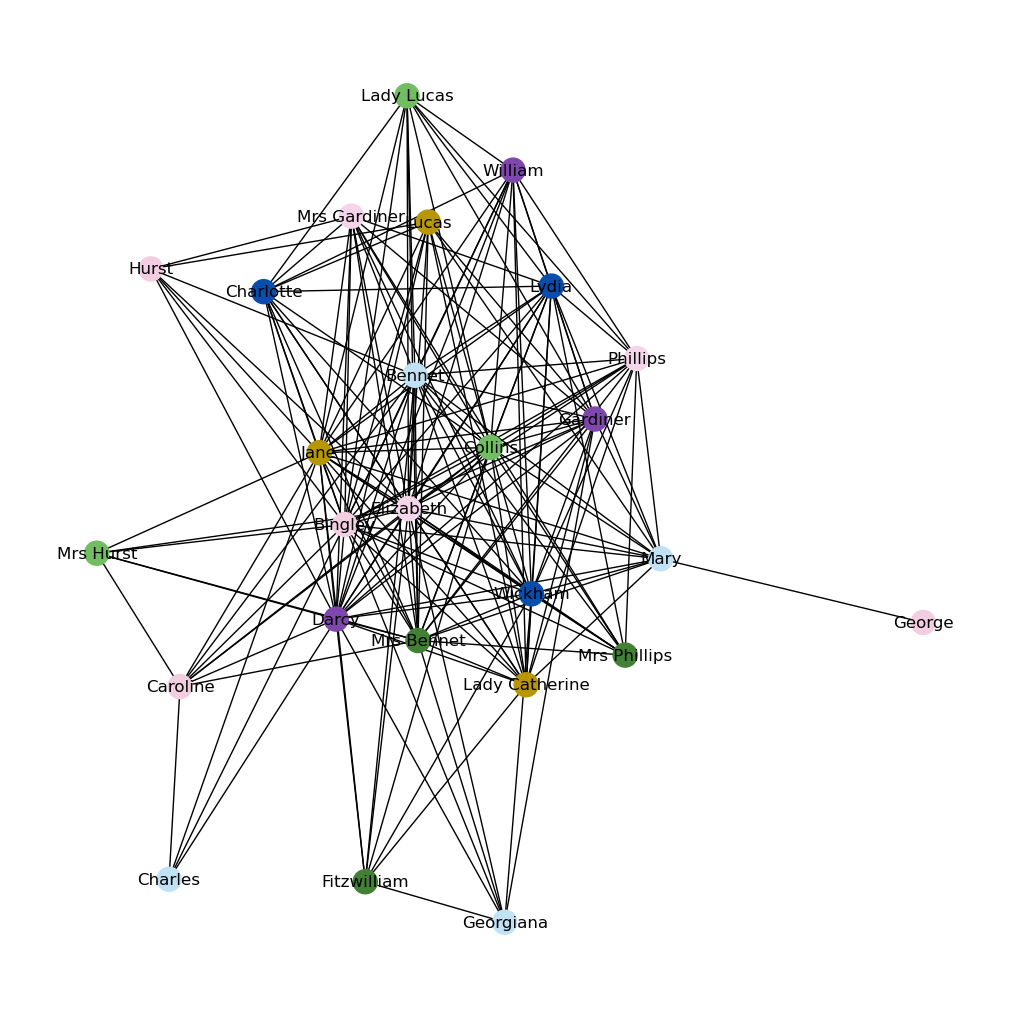

In [106]:
colors = ['#c1e1f5', '#f2cee0', '#7f47ad', '#71bd62', '#b89706','#094dad','#f5d5ea','#428036']
color_cycle = cycle(colors) 
color_map = {node: next(color_cycle) for node in G.nodes()}

plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color=[color_map[node] for node in G.nodes()], edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [125]:
from pyvis.network import Network
net = Network(notebook = True, cdn_resources="remote",width="100%", height="1000", bgcolor='#000', font_color='white')

#net.show_buttons(filter_=['physics'])

node_degree = dict(G.degree)
node_values = {node: sum(data['value'] for _, _, data in G.edges(node, data=True)) for node in G.nodes()}


for node in G.nodes():
    net.add_node(node, color=color_map[node], size=node_values[node] / 100) 

# Add edges from G to the Pyvis network
for edge in G.edges(data=True):
    net.add_edge(edge[0], edge[1], value=edge[2]['value'])

net.options.physics.enabled = True
net.options.physics.barnesHut = {
    "gravitationalConstant": -15000,
    "centralGravity": 0.001,
    "springLength": 300,
    "springConstant": 0.05
}

# Show the network
net.show("ppp2.html")

ppp2.html


In [127]:
import json

In [128]:
nodes = [{'id': node, 'label': node, 'value': node_values[node]} for node in G.nodes()]
edges = [{'from': u, 'to': v, 'value': d['value']} for u, v, d in G.edges(data=True)]

In [129]:
nodes_json = json.dumps(nodes)
edges_json = json.dumps(edges)

# Optionally save to a file
with open('nodes.json', 'w') as f:
    f.write(nodes_json)
with open('edges.json', 'w') as f:
    f.write(edges_json)

In [130]:
node_data = [
    {
        'id': node,
        'label': node,
        'color': color_map[node],
        'value': node_values[node]
    } for node in G.nodes()
]

edge_data = [
    {
        'from': u,
        'to': v,
        'value': d['value']
    } for u, v, d in G.edges(data=True)
]

# Combining node and edge data
graph_data = {
    'nodes': node_data,
    'edges': edge_data
}

# Save to a JSON file
with open('graph_data.json', 'w') as f:
    json.dump(graph_data, f, indent=2)

In [113]:
# Degree centrality
degree_dict = nx.degree_centrality(G)
degree_dict

{'Bennet': 0.76,
 'Bingley': 0.92,
 'William': 0.52,
 'Lady Lucas': 0.44,
 'Jane': 0.92,
 'Lydia': 0.68,
 'Elizabeth': 0.92,
 'Mrs Bennet': 0.8,
 'Mary': 0.56,
 'Hurst': 0.28,
 'Darcy': 0.88,
 'Mrs Hurst': 0.24,
 'Lucas': 0.44,
 'Charlotte': 0.52,
 'Phillips': 0.56,
 'Mrs Phillips': 0.4,
 'Charles': 0.16,
 'Caroline': 0.36,
 'Gardiner': 0.64,
 'Collins': 0.8,
 'Lady Catherine': 0.64,
 'Wickham': 0.72,
 'Mrs Gardiner': 0.52,
 'Fitzwilliam': 0.32,
 'Georgiana': 0.28,
 'George': 0.04}

In [114]:
sorted_degrees = dict(sorted(G.degree, key=lambda x: x[1], reverse=True))

sorted_degrees

{'Bingley': 23,
 'Jane': 23,
 'Elizabeth': 23,
 'Darcy': 22,
 'Mrs Bennet': 20,
 'Collins': 20,
 'Bennet': 19,
 'Wickham': 18,
 'Lydia': 17,
 'Gardiner': 16,
 'Lady Catherine': 16,
 'Mary': 14,
 'Phillips': 14,
 'William': 13,
 'Charlotte': 13,
 'Mrs Gardiner': 13,
 'Lady Lucas': 11,
 'Lucas': 11,
 'Mrs Phillips': 10,
 'Caroline': 9,
 'Fitzwilliam': 8,
 'Hurst': 7,
 'Georgiana': 7,
 'Mrs Hurst': 6,
 'Charles': 4,
 'George': 1}

<Axes: >

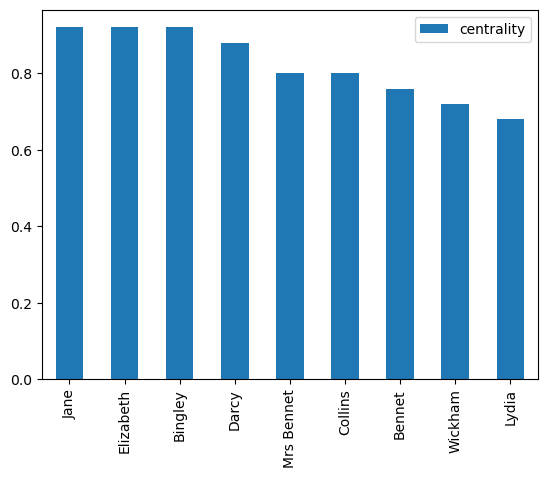

In [115]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
degree_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

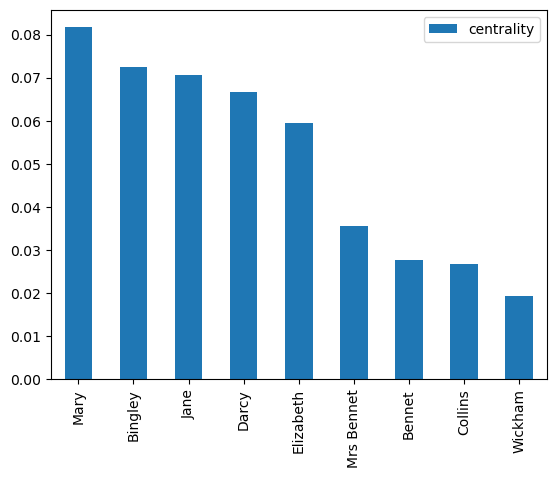

In [116]:
# Betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
betweenness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

<Axes: >

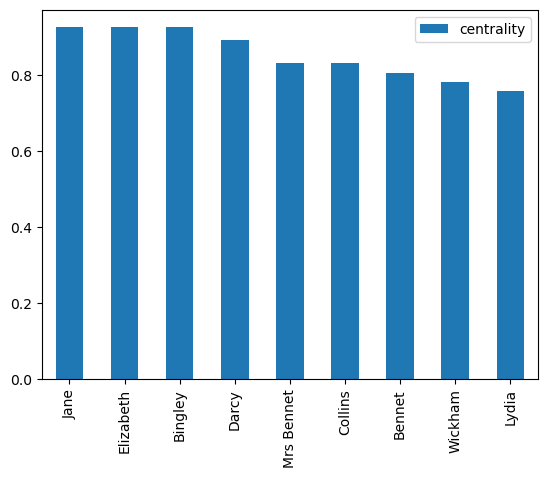

In [117]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
# Plot top 10 nodes
closeness_df.sort_values('centrality', ascending=False)[0:9].plot(kind="bar")

In [118]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')

# community detection

In [119]:
import community as community_louvain

In [120]:
communities = community_louvain.best_partition(G)
communities

{'Bennet': 3,
 'Bingley': 1,
 'William': 2,
 'Lady Lucas': 2,
 'Jane': 1,
 'Lydia': 2,
 'Elizabeth': 3,
 'Mrs Bennet': 3,
 'Mary': 0,
 'Hurst': 1,
 'Darcy': 1,
 'Mrs Hurst': 1,
 'Lucas': 1,
 'Charlotte': 2,
 'Phillips': 2,
 'Mrs Phillips': 3,
 'Charles': 1,
 'Caroline': 1,
 'Gardiner': 3,
 'Collins': 2,
 'Lady Catherine': 2,
 'Wickham': 3,
 'Mrs Gardiner': 3,
 'Fitzwilliam': 3,
 'Georgiana': 3,
 'George': 0}

In [121]:
nx.set_node_attributes(G,communities, 'group')

In [124]:
com_net = Network(notebook = True, width="100%", height="700px", bgcolor='#000000', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
doubled_size = {node: degree * 2.5 for node, degree in node_degree.items()}
nx.set_node_attributes(G, doubled_size, 'size')

com_net.options.physics.enabled = True
com_net.options.physics.solver = 'forceAtlas2Based'  # or 'repulsion'
com_net.options.physics.forceAtlas2Based = {
    "gravitationalConstant": -100,
    "centralGravity": 0.005,
    "springLength": 200,
    "springConstant": 0.05,
}

com_net.from_nx(G)
com_net.show("witcher_communities.html")

witcher_communities.html


# evolution of characters' importance

In [117]:
import pandas as pd
import numpy as np
import os
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt


In [126]:
from liab.utils.functionss import *

In [127]:
books_graph = []

def sort_key(file_path):
    """Extract numerical part from filename and convert to integer."""
    base_name = os.path.basename(file_path)
    name, ext = os.path.splitext(base_name)
    return int(name)

# Ensure 'Chapters' is the correct path and it contains your .txt files
directory_path = 'Chapters'
all_books = [b for b in os.scandir(directory_path) if b.name.endswith('.txt')]

# Sort using the defined sort_key function
all_books.sort(key=sort_key)

In [128]:
characters_df.head()

index   firstname     lastname
0    1.0   Elizabeth       Bennet
1    2.0    Mr Darcy  Fitzwilliam
2    3.0   Mr Bennet          NaN
3    4.0  Mrs Bennet          NaN
4    5.0        Jane       Bennet

In [129]:
import networkx as nx

# Assuming 'all_books' contains chapters as separate items or there's a way to divide books into chapters
books_graph = []  # To store graphs of all books or chapters

for book in all_books:
    # Presuming 'ner' function processes text and returns named entities; adjust if it operates differently
    book_text = ner(book)  # Apply named entity recognition

    # Get list of entities per sentence
    sent_entity_df = get_ne_list_per_sentence(book_text)
    
    # Select only character entities
    sent_entity_df['characters_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))  # Adjust 'character_df' as needed

    # Filter out sentences that don't have any character entities
    sent_entity_df_filtered = sent_entity_df[sent_entity_df['characters_entities'].map(len) > 0]
    
    # Take only the first name of characters for simplicity
    sent_entity_df_filtered['characters_entities'] = sent_entity_df_filtered['characters_entities'].apply(lambda x: [item.split()[0] for item in x])

    # Create relationships DataFrame based on the filtered entity DataFrame
    relationship_df = create_relationships(df=sent_entity_df_filtered, window_size=5)
    
    # Create a graph from the pandas DataFrame
    G = nx.from_pandas_edgelist(relationship_df, source="source", target="target", edge_attr="value", create_using=nx.Graph())
    
    books_graph.append(G)

# Visualization or analysis of 'books_graph' follows here

/var/folders/x4/gn012t7s4n1867l1f1_5g6rm0000gn/T/ipykernel_25238/242797932.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['characters_entities'] = sent_entity_df_filtered['characters_entities'].apply(lambda x: [item.split()[0] for item in x])
/var/folders/x4/gn012t7s4n1867l1f1_5g6rm0000gn/T/ipykernel_25238/242797932.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered['characters_entities'] = sent_entity_df_filtered['characters_entities'].apply(lambda x:

KeyError: 'source'

<Axes: >

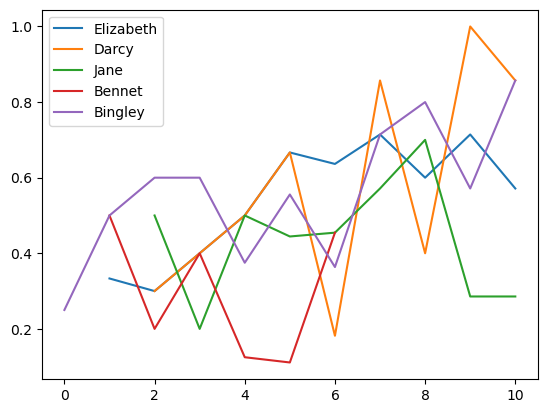

In [229]:
# Creating a list of degree centrality of all the books
evol = [nx.degree_centrality(book) for book in books_graph]

# Creating a DataFrame from the list of degree centralities in all the books
degree_evol_df = pd.DataFrame.from_records(evol)

# Plotting the degree centrality evolution of 5 main characters
degree_evol_df[["Elizabeth", "Darcy", "Jane", "Bennet", "Bingley"]].plot()